In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
#pip install mycolorpy

In [3]:
#pip install colour

In [4]:
#pip install fitparse


In [5]:
from fitparse import FitFile
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import datetime
from mycolorpy import colorlist as mcp
import numpy as np
import re
import matplotlib.dates as mdates

cycle_starts = [pd.Timestamp("2024-11-23"), pd.Timestamp("2024-12-21"), pd.Timestamp("2025-01-18"), pd.Timestamp("2025-02-11"), pd.Timestamp("2025-03-10")]


class FitDataProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = self._read_fit_file()
        self.compute_cycle_day()
        self._pause = 0.0
        
    @property
    def date(self):
        return self._date
    
    @property
    def cycle_day(self):
        return self._cycle_day
    
    @property
    def average_heartrate(self):
        return self._average_heartrate
    
    @property
    def pace(self):
        minuten = (self.df["timestamp"].max()- self.pause) /60  
        avg_pace =  minuten/ (self.distance  /1000)
        return avg_pace
    
    @property
    def distance(self):
        return self._distance
    
    @property
    def pause(self):
        return self._pause
    
    def set_pause(self, value):
        self._pause = value
        
    def _read_fit_file(self):
        """Reads a FIT file and extracts timestamp, distance, and heart rate."""
        fitfile = FitFile(self.file_path)
        timestamps, distances, heart_rates, paces = [], [], [], []
        
        
        for record in fitfile.get_messages("record"):
            timestamp = record.get_value("timestamp")
            distance = record.get_value("distance")  # In meters
            heart_rate = record.get_value("heart_rate")
            
            if timestamp and distance and heart_rate:
                timestamps.append(timestamp)
                distances.append(distance)
                heart_rates.append(heart_rate)
        
        df = pd.DataFrame({"timestamp": timestamps, "distance": distances, "heart_rate": heart_rates})
        # Convert timestamp to seconds relative to start
        df["timestamp"] = (df["timestamp"] - df["timestamp"].iloc[0]).dt.total_seconds()
        self._date = record.get_value("timestamp").strftime('%Y-%m-%d')   
        if self._date == "2019-01-01":
            print("error in file, set to correct date")
            self._date = "2025-02-17"
        self._distance = df.iloc[-1]['distance']
        self._average_heartrate = np.mean(df["heart_rate"])
        print(self._date)
        return df
    
    def compute_cycle_day(self):
         # Extract dates and values
        date = pd.Timestamp(self.date)
        cycle_start = max([d for d in cycle_starts if d <= date])  # Find the correct cycle start
        self._cycle_day = (date - cycle_start).days 
    
    def _extract_200m_data(self, interval=1000):
        """Extracts data at approximately every given interval (default 1000m)."""
        selected_distances = list(range(interval, int(self.df["distance"].max()), interval))
        df_200m = self.df.loc[self.df["distance"].apply(lambda x: min(selected_distances, key=lambda d: abs(d - x))).drop_duplicates().index]
        # Calculate pace (time per km in min/km)
        df_200m["pace"] = (df_200m["timestamp"].diff() / df_200m["distance"].diff()) * 1000 / 60  # min/km
        df_200m = df_200m.dropna()
        return df_200m
    
    def plot_heart_rate_vs_pace(self, interval=1000):
        """Plots heart rate as a function of pace."""
        df_200m = self._extract_200m_data(interval=interval)
        plt.figure(figsize=(8, 5))
        plt.scatter(df_200m["pace"], df_200m["heart_rate"], color="red", 
                    label=f"distance: {self._distance}, date: {self.date}")
        plt.xlabel("Pace (min/km)")
        plt.ylabel("Heart Rate (bpm)")
        plt.title("Heart Rate as a Function of Pace")
        plt.grid(True)
        plt.legend()
        plt.show()

class CollatedFitDataProcessors:
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.sorted_files, self.sorted_dates = self._get_fit_file_names_and_dates()
        self.processors = [FitDataProcessor(file) for file in self.sorted_files]
    
    def _get_fit_file_names_and_dates(self):
        """Returns sorted lists of FIT file names and their corresponding dates."""
        files = glob.glob(os.path.join(self.folder_path, "Running*.fit"))
        
        file_dates =  [re.search("([0-9]{4}\-[0-9]{2}\-[0-9]{2})", fileName).group(1) for fileName in files]
        
        # Sort files by date
        sorted_files_dates = sorted(zip(files, file_dates), key=lambda x: x[1])
        sorted_files, sorted_dates = zip(*sorted_files_dates) if sorted_files_dates else ([], [])
        
        return list(sorted_files), np.array(sorted_dates)
    
    def _format_pace(self, pace_in_minutes):
        """Convert pace from minutes per kilometer to 'min' 'sec' format."""
        minutes = int(pace_in_minutes)
        seconds = int((pace_in_minutes - minutes) * 60)
        return f"{minutes}' {seconds}\""

    def get_color_for_distance(self):
        c_short = 'tab:orange'
        c_long = 'tab:green'
        c_5 = 'tab:red'
        c_sonst = 'tab:blue'
        colors, markers = [], []
        for p in self.processors:
            c = c_sonst
            if p.distance > 10000:
                c = c_long
            if p.distance < 2500:
                c = c_short
            if p.distance < 5100 and p.distance > 4900:
                c = c_5
            colors.append(c)
            if '2024-12' in p.date:
                markers.append('x')
            if '2025-01' in p.date:
                markers.append('o')
            if '2025-02' in p.date:
                markers.append('+')
            if '2025-03' in p.date:
                markers.append('*')
        return colors, markers
    
    def plot_heart_rate_vs_pace(self, interval=1000, fit = True,
                               style = 'default'):
        """Plots all heart rate vs pace data from different files with a gradient color scale based on time."""
        if not self.processors:
            print("No data available for plotting.")
            return
        if style == 'default':
            colors=mcp.gen_color(cmap="spring_r",n = len(self.sorted_dates))
            markers = ['x','o','+','s','^','>', '*'] * 10
        else:
            colors, markers = self.get_color_for_distance()
        plt.figure(figsize=(8, 5))
        
        i = 0 
        paces, heartrates = [], []
        for processor in (self.processors):
            paces.append(processor.pace)
            heartrates.append(processor._average_heartrate)
            formatted_pace = self._format_pace(processor.pace)
            label_text = f"{processor.date} ({formatted_pace}, {(processor.distance/1000):.3} km)"
            plt.errorbar(processor.pace, processor._average_heartrate, 
                                  color=colors[i],  label=label_text, 
                         elinewidth = 0.2, markersize = markersize[markers[i]],
                        marker = markers[i])
            i+=1
        
        plt.xlabel("Pace (min/km)")
        plt.ylabel("Heart Rate (bpm)")
        plt.title("Heart Rate as a Function of Pace (Color by Time)")
        plt.grid(True)
        plt.legend(loc="upper left", bbox_to_anchor=(1, 1),  fontsize="small",)
        
        
        if fit: 
            #m, b = np.polyfit(paces, heartrates, 2)
            pace_range = np.linspace(min(paces), max(paces), 1000)
            #fit_line = m * pace_range + b
            z = np.polyfit(paces, heartrates, 3)
            p = np.poly1d(z)
            _ = plt.plot(pace_range, p(pace_range), '-')
            fit_line  = p(pace_range)
            #plt.plot(pace_range, fit_line, color="grey",
            #         linestyle="--", alpha= 0.3)#, label=f"Fit: HR = {m:.2f} * Pace + {b:.2f}")
            distances = []
            for p_x, p_y in zip(paces, heartrates):
                ddx = (pace_range - p_x)
                ddy = (fit_line - p_y)
                dd = np.min(np.sqrt(ddx**2 + ddy**2))
                
                sign = -1
                pace_soll = pace_range[np.argmin(( pace_range- p_x)**2)]
                heartrate_soll =  p(pace_soll)# m * pace_soll + b
                if heartrate_soll > p_y:
                    sign = +1 
                distances.append(dd *sign )
            self.distances = distances
        plt.show()

    def plot_distances_vs_cycle_day(self):
        
        for pro, dist in zip(self.processors, self.distances):
            plt.scatter(pro.cycle_day, dist, color= 'tab:blue')
            #plt.scatter(pro.pace(), dist, color= 'tab:blue')
        plt.scatter(self.processors[-1].cycle_day, self.distances[-1], marker = 'x')
        plt.ylabel("Deviation from Fit [arb. unit]")
        plt.xlabel("Cycle Day")
        plt.gca().set_ylim(np.min(self.distances) -2, 
                           np.max(self.distances) + 2)
        yy = plt.gca().get_ylim()
        
        if True:
            plt.fill_betweenx(y = (yy[0],yy[1]), x1 = 0, x2 = 4,  color = 'tab:red', alpha = 0.2)
            plt.text(-1, yy[1]- 1 , 'Menstruation', color = 'tab:red')
            plt.fill_betweenx(y = (yy[0],yy[1]), x1 = 4, x2 = 13,  color = 'tab:orange', alpha = 0.2)
            plt.text(6.6, yy[1]- 1 , 'Follicular', color = 'tab:orange')
            plt.fill_betweenx(y = (yy[0],yy[1]), x1 = 13, x2 = 15,  color = 'tab:green', alpha = 0.2)
            plt.text(12, yy[1]- 1 , 'Ovulation', color = 'tab:green')
            plt.fill_betweenx(y = (yy[0],yy[1]), x1 = 15, x2 = 28,  color = 'tab:purple', alpha = 0.2)
            plt.text(20, yy[1]- 1 , 'Luteal', color = 'tab:purple')
            
        plt.plot([0,28], [0,0], color = 'grey', alpha = 0.4)
        plt.text(25, 2, 'better',  color = 'grey',)       
        plt.text(25, -2, 'worse',  color = 'grey',)
    
    def select_by_date(self, date):
        for processor in self.processors:
            if processor.date == date:
                return processor
        

In [6]:
# Example usage:
collated_processors = CollatedFitDataProcessors("data/")

2024-12-19
2024-12-19
2025-01-02
2025-01-04
2025-01-14
2025-01-20
2025-01-21
2025-01-23
2025-01-26
2025-01-28
2025-02-03
2025-02-04
2025-02-05
2025-02-08
2025-02-08
2025-02-10
error in file, set to correct date
2025-02-17
2025-02-18
2025-02-19
2025-02-21
2025-02-23
2025-02-24
2025-02-28
2025-03-03
2025-03-06
2025-03-07


In [11]:
pr = collated_processors.select_by_date('2025-03-07').set_pause(146)
pr = collated_processors.select_by_date('2025-03-03').set_pause(11* 60)
pr = collated_processors.select_by_date('2025-02-28').set_pause(15* 60)
pr = collated_processors.select_by_date('2025-02-24').set_pause(90)
pr = collated_processors.select_by_date('2025-02-23').set_pause(8*60 + 33)
pr = collated_processors.select_by_date('2025-02-21').set_pause(15*60 + 25)
pr = collated_processors.select_by_date('2025-02-19').set_pause(2*60 + 17)
pr = collated_processors.select_by_date('2025-02-18').set_pause(1*60 + 12)
pr = collated_processors.select_by_date('2025-02-17').set_pause(8*60 + 53)
pr = collated_processors.select_by_date('2025-02-17').set_pause(8*60 + 53)
pr = collated_processors.select_by_date('2025-02-10').set_pause(2*60 + 21)
pr = collated_processors.select_by_date('2025-02-08').set_pause(1*60 + 12)
pr = collated_processors.select_by_date('2025-02-05').set_pause(1*60 + 2)


/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


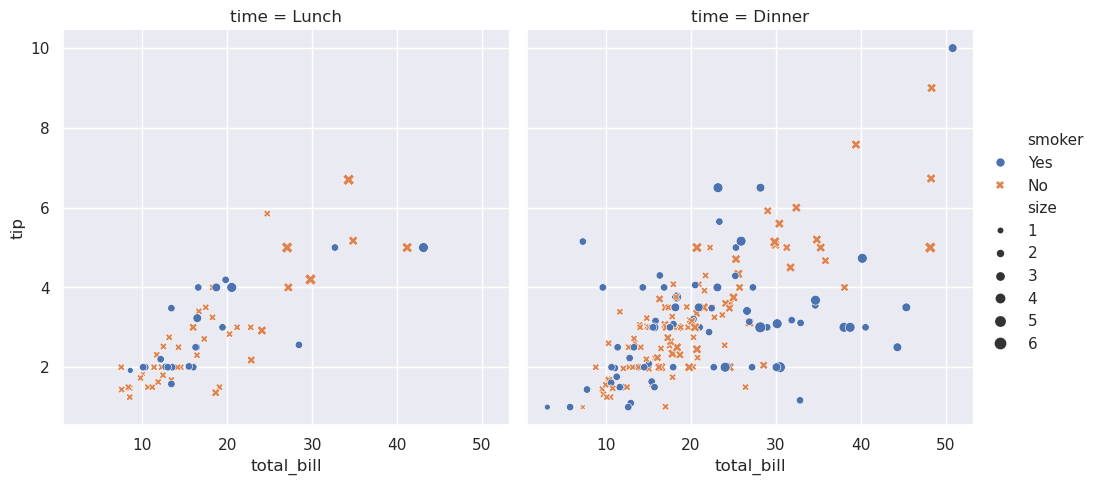

In [12]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

# Load an example dataset
tips = sns.load_dataset("tips")

# Create a visualization
sns.relplot(
    data=tips,
    x="total_bill", y="tip", col="time",
    hue="smoker", style="smoker", size="size",
)

In [13]:
paces = [p.pace for p in collated_processors.processors]
distances = [p.distance for p in collated_processors.processors]
heart_rates = [p._average_heartrate for p in collated_processors.processors]

def get_type(d): 
    t = 'normal'
    if d>10000:
        t = "long"
    if d < 2500:
        t = "short"
    if d > 4900 and d < 5100:
        t = "5k"
    return t 
types = [get_type(d) for d in distances]


def get_month(p):
    if "2024-12" in p.date:
        return 0 
    if "2025-01" in p.date:
        return 1
    if "2025-02" in p.date:
        return 2
months = [get_month(p) for p in collated_processors.processors]


def get_phase(p):
    c = p.cycle_day
    if  c<= 4:
        ph = 'menstruation'
    if  c> 4 and c<=13:
        ph = 'follicular'
    if  c> 13 and c<=15:
        ph = 'Ovulation'
    if  c> 15 and c<=28:
        ph = 'Luteal'
    return ph 

phases = [get_phase(p) for p in collated_processors.processors]
        
        
import pandas as pd

# initialize data of lists.
data = {'paces': paces, 
        'heartrate' : heart_rates,
       'type':types, 
       'months':months,
       'phases':phases}

# Create DataFrame
data = pd.DataFrame(data)

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


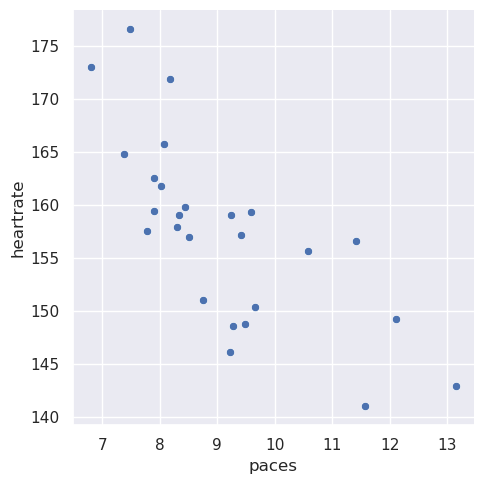

In [14]:
sns.relplot(
    data=data,
    x="paces", y="heartrate",)

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


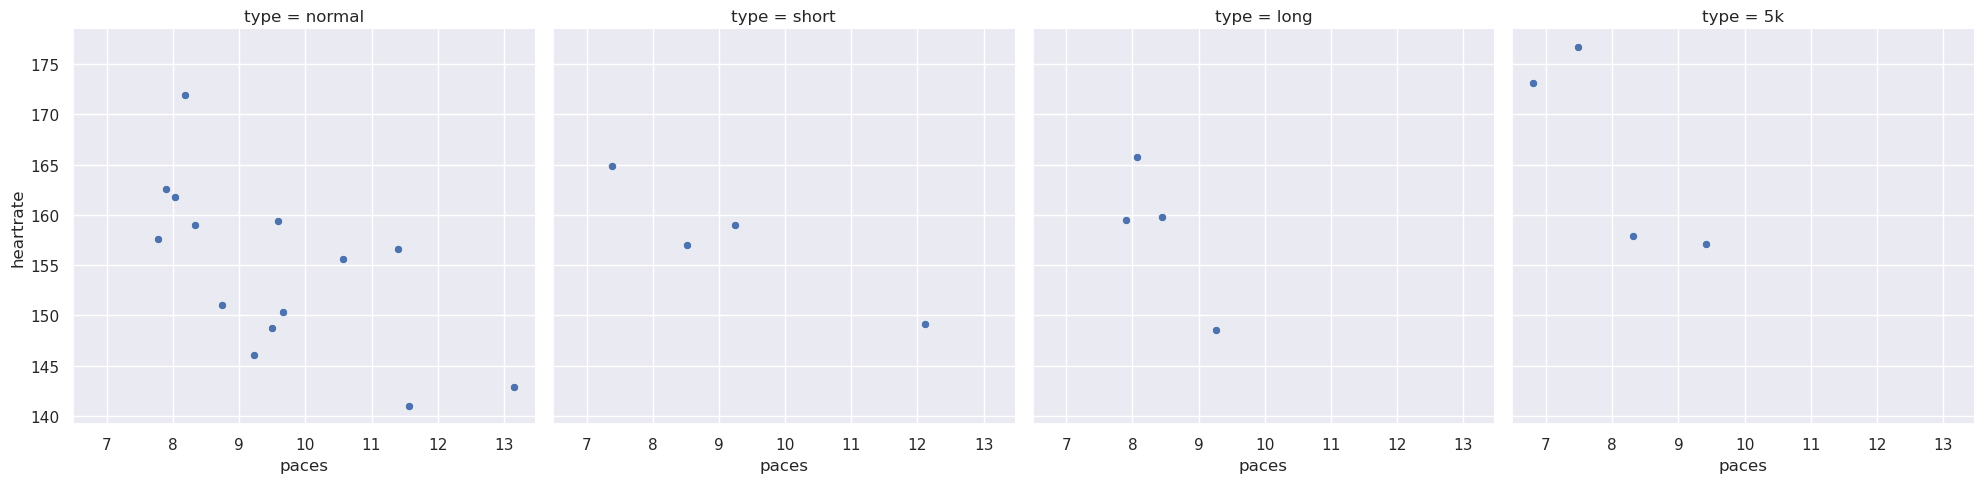

In [15]:
sns.relplot(
    data=data,
    x="paces", y="heartrate", col="type"
)

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


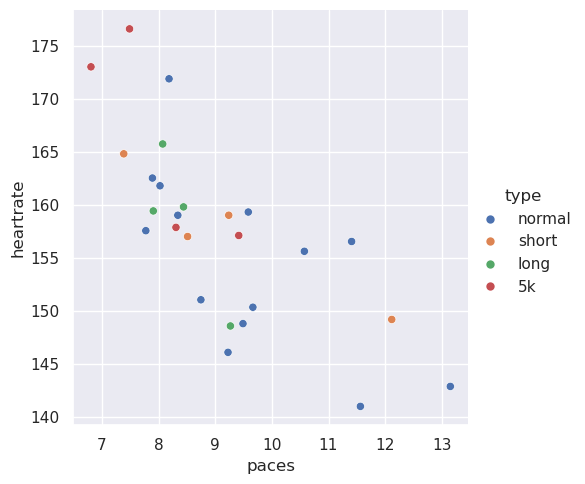

In [16]:
sns.relplot(
    data=data,
    x="paces", y="heartrate", hue="type"
)

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


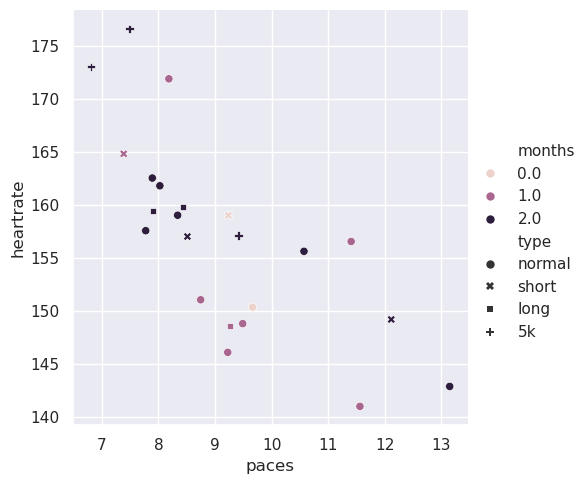

In [17]:
sns.relplot(
    data=data,
    x="paces", y="heartrate",style="type",  hue = 'months'
)

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


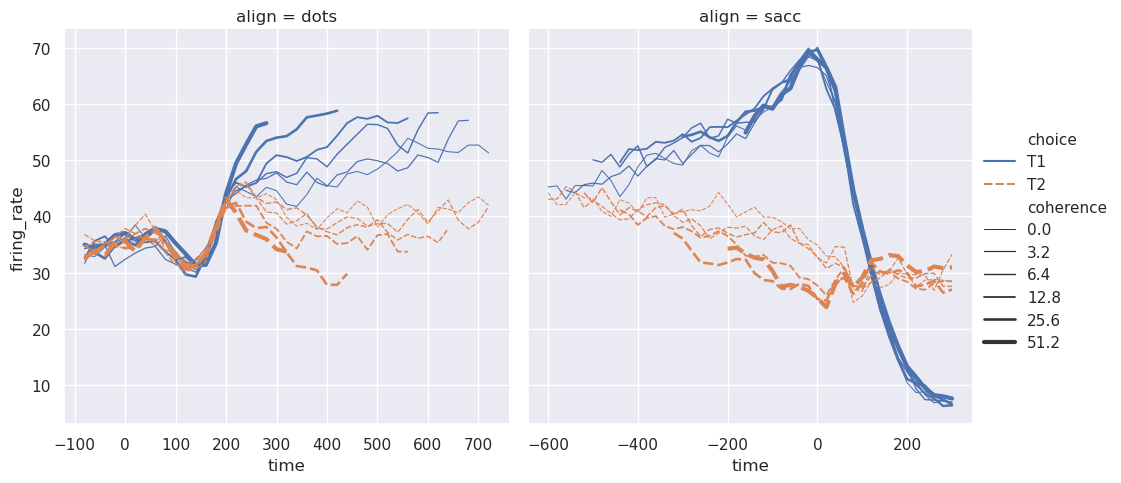

In [18]:
dots = sns.load_dataset("dots")
sns.relplot(
    data=dots, kind="line",
    x="time", y="firing_rate", col="align",
    hue="choice", size="coherence", style="choice",
    facet_kws=dict(sharex=False),
)

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


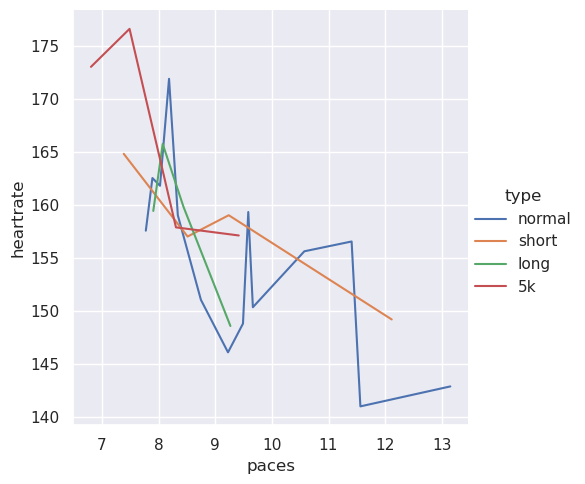

In [19]:
sns.relplot(
    data=data, kind="line",
    x="paces", y="heartrate", #col="months",
    hue="type", #size="coherence", style="choice",
    facet_kws=dict(sharex=False),
)

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


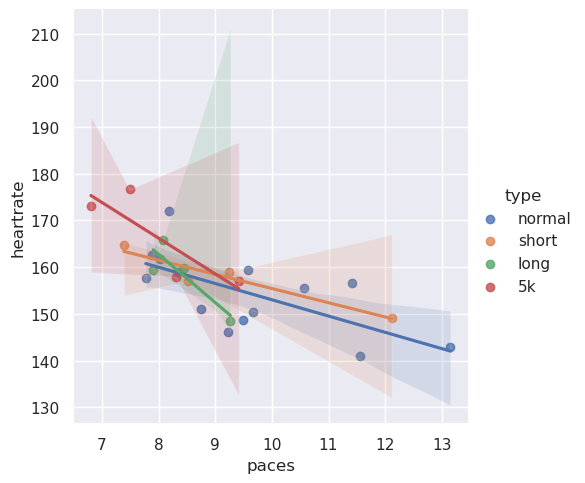

In [20]:
sns.lmplot(data=data, x="paces", y="heartrate", hue = 'type')# col="types",)# hue="smoker")

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


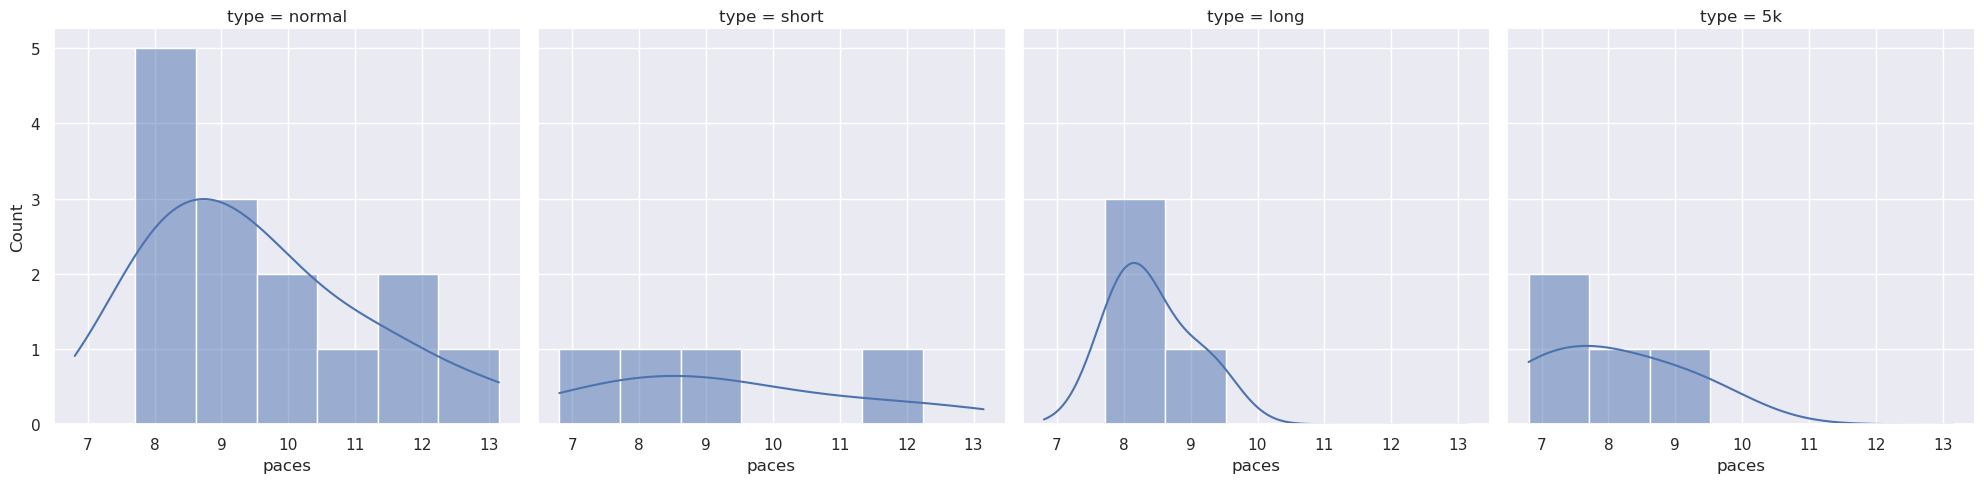

In [21]:
sns.displot(data=data, x="paces", col="type", kde=True)

/home/katrin/anaconda3/envs/gammapy-dev/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


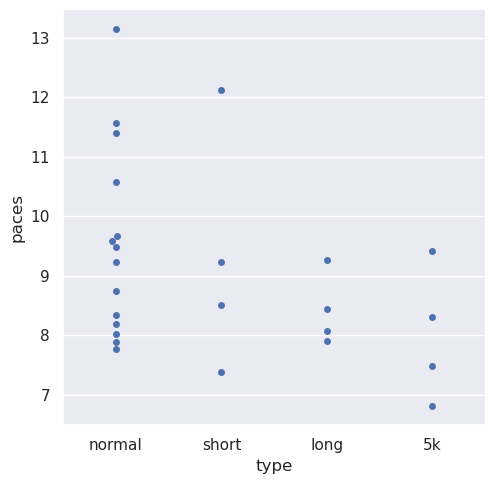

In [22]:
sns.catplot(data=data, kind="swarm", x="type", y="paces")#, hue="smoker")

In [23]:
#sns.catplot(data=data, kind="violin",x="type", y="paces", )#hue="type", split=True)

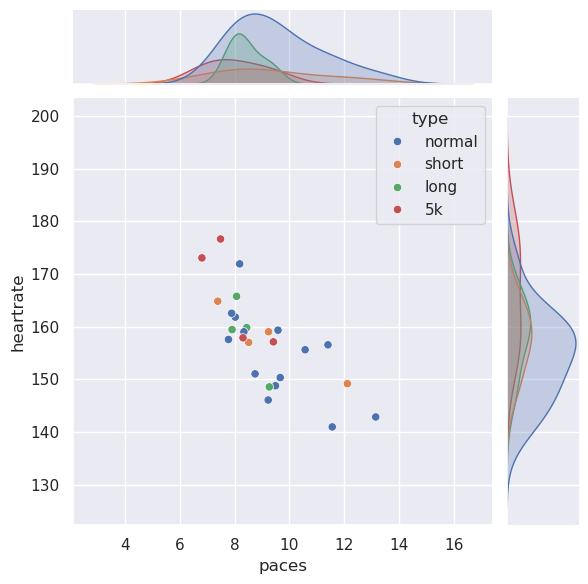

In [24]:
sns.jointplot(data=data, x="paces", y="heartrate", hue="type")


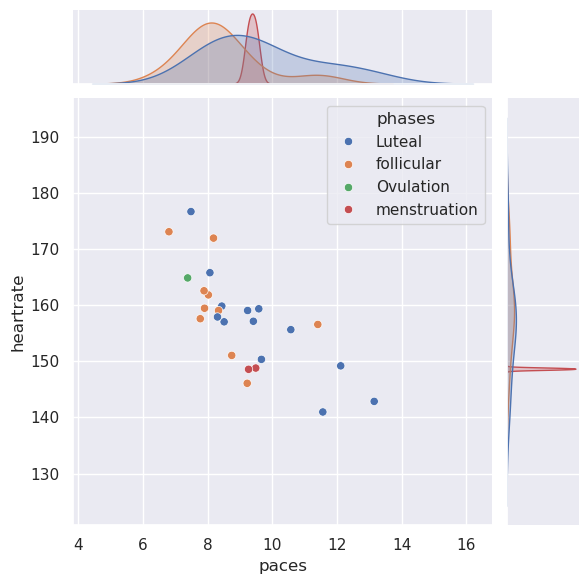

In [25]:
sns.jointplot(data=data, x="paces", y="heartrate", hue="phases")
            
